# Exercise 8.8

<p style="text-align: justify;">
Replicate the experiment whose results are shown in the figures below, then try the same experiment but with $b = 3$. Discuss the meaning of your results.
</p>

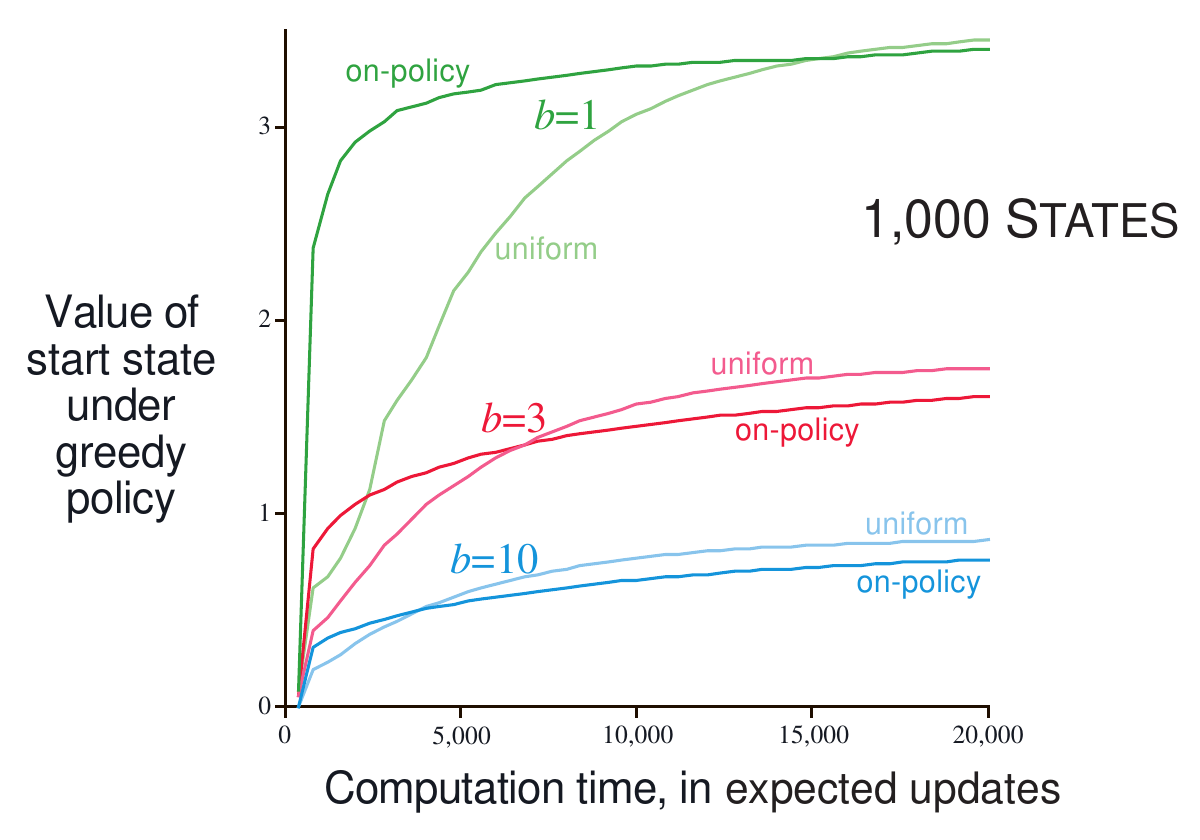

In [1]:
from IPython.display import Image
Image('ch08_ex08/fig8_8_upper.png', width=600)

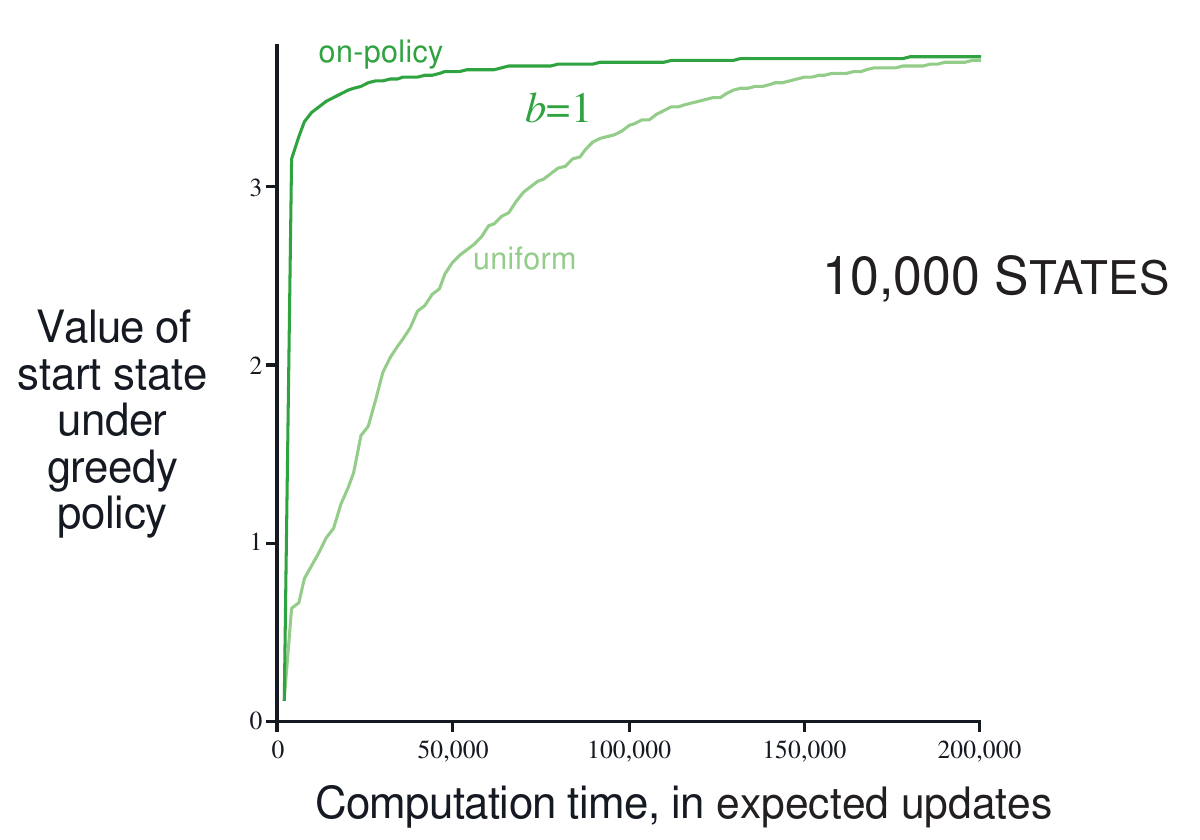

In [2]:
Image('ch08_ex08/fig8_8_lower.png', width=600)

## Experiment definition

<p style="text-align: justify;">
We conducted a small experiment to assess the effect empirically. To isolate the effect of the update distribution, we used entirely one-step expected tabular updates, as defined by 
</p>

$$
Q(s, a) \leftarrow \sum_{s', r} \hat{p}(s', r | s, a) \big[ r + \gamma \max_{a'} Q(s', a') \big]
$$

<p style="text-align: justify;">
In the uniform case, we cycled through all state–action pairs, updating each in place, and in the on-policy case we simulated episodes, all starting in the same state, updating each state–action pair that occurred under the current $\epsilon$-greedy policy ($\epsilon = 0.1$). The tasks were undiscounted episodic tasks ($\gamma = 1$), generated randomly as follows. From each of the |$\mathcal{S}$| states, two actions were possible, each of which resulted in one of $b$ next states, all equally likely, with a different random selection of $b$ states for each state–action pair. The branching factor, $b$, was the same for all state–action pairs. In addition, on all transitions there was a $0.1$ probability of transition to the terminal state, ending the episode. The expected reward on each transition was selected from a Gaussian distribution with mean $0$ and variance $1$. At any point in the planning process one can stop and exhaustively compute $v_{\hat{\pi}}(s_{0})$, the true value of the start state under the greedy policy, $\hat{\pi}$, given the current action-value function $Q$, as an indication of how well the agent would do on a new episode on which it acted greedily (all the while assuming the model is correct).
</p>

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

%matplotlib inline

## Settings

In [4]:
EPSILON  = 0.1
GAMMA    = 1.0
END_PROB = 0.1

N_ACTIONS = 2
N_RUNS = 30
V_RUNS = 1000

DISTROS = {
    'uniform',
    'on-policy'
}

Vs = dict()

ALL_ACTIONS = np.arange(N_ACTIONS)
ALL_STATES = None
R, T = None, None

## Functions

In [5]:
def get_best_action(q):
    return np.random.choice(np.argwhere(q == q.max()).reshape(-1))

In [18]:
def plot_vs(Vs, n_states):
    plt.figure(figsize=(16, 9))

    legend = []

    idx = None
    for b_factor in Bs:
        for distr in DISTROS:
            V = []
            
            for vs in Vs[b_factor][distr]:
                xticks, v = zip(*vs)
                V += [v]
                
            V = np.mean(np.asarray(V), axis=0)
            idx = np.arange(len(xticks))
            legend += [f'{distr.capitalize()}; b = {b_factor}']
            plt.plot(xticks, V[idx])

    plt.title(f'{n_states} states')
    plt.xlabel('Computation time, in expected updates')
    plt.ylabel('Value of start state under greedy policy')
    plt.legend(legend)
    plt.show()
    
    return

In [7]:
def iterate(b_factor, distr, epsilon=EPSILON, gamma=GAMMA, *args):
    if distr not in DISTROS:
        print('Unknown distribution!')
        return

    # Define variables
    Q = np.zeros((N_STATES, N_ACTIONS))  # State-action values
    V = []  # State value of S[0] through time
    
    # Set-up starting state
    s = 0
        
    for it in range(N_ITERS):
        if distr == 'uniform':
            s = np.random.choice(ALL_STATES)
            
        # Choose action according to the on-policy
        a = get_best_action(Q[s])
        
        if np.random.uniform() < epsilon or distr == 'uniform':
            a = np.random.choice(ALL_ACTIONS)
            
        t  = T[s][a]  # List of next states
        
        # The calculation is the same regardless of the policy type
        Q[s][a] = (1 - END_PROB) * (R[t] + GAMMA * Q[t].max(axis=1)).mean()
            
        # Calculate V for the initial state
        if it == 0:
            V += [(0, 0.0)]
        elif it % MOD == 0:
            returns = np.zeros((V_RUNS, ))
            for it_ in range(V_RUNS):
                rewards = 0
                s = 0
                flip = 1.0

                while flip >= END_PROB:
                    a = get_best_action(Q[s])
                    s = np.random.choice(T[s][a])
                    returns[it_] += R[s]
                    flip = np.random.uniform()
            V += [(it, returns.mean())]
            
        # Choose next state
        if np.random.uniform() < END_PROB:
            s = 0
        else:
            s = np.random.choice(t)
      
    return V

In [8]:
def run():
    global ALL_STATES, R, T
    
    ALL_STATES = np.arange(N_STATES)

    R = np.random.normal(size=N_STATES)  # Rewards

    Vs = dict()

    for b_factor in Bs:
        Vs.setdefault(b_factor, dict())

        # Generate transitions
        T = dict()

        for s in ALL_STATES:
            T.setdefault(s, dict())

            for a in ALL_ACTIONS:
                T[s][a] = np.random.choice(ALL_STATES, size=b_factor, replace=False)

        # Iterate
        for distr in DISTROS:
            Vs[b_factor][distr] = []
            for _ in tqdm(range(N_RUNS)):
                Vs[b_factor][distr] += [iterate(b_factor, distr)]
                
    return Vs

### 1,000 states

In [9]:
# Define constants
Bs = [1, 3, 10]
MOD = 200
N_STATES  = 1000
N_ITERS = 20000

Vs[N_STATES] = run()

100%|██████████| 30/30 [14:16<00:00, 30.84s/it]


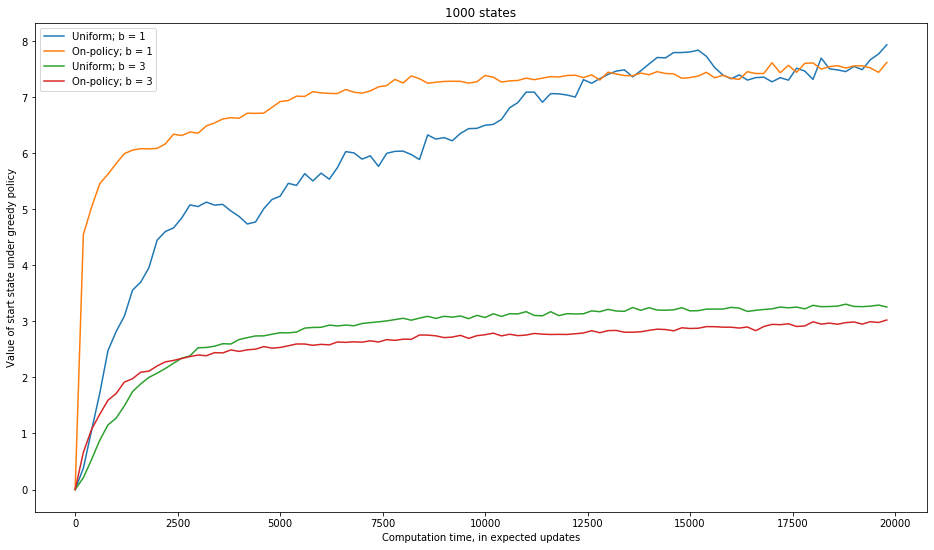

In [23]:
plot_vs(Vs[1000], 1000)

### 10,000 states

In [11]:
# Define constants
Bs = [1, 3]
MOD = 2000
N_STATES  = 10000
N_ITERS = 200000

Vs[N_STATES] = run()

100%|██████████| 30/30 [18:22<00:00, 36.78s/it]


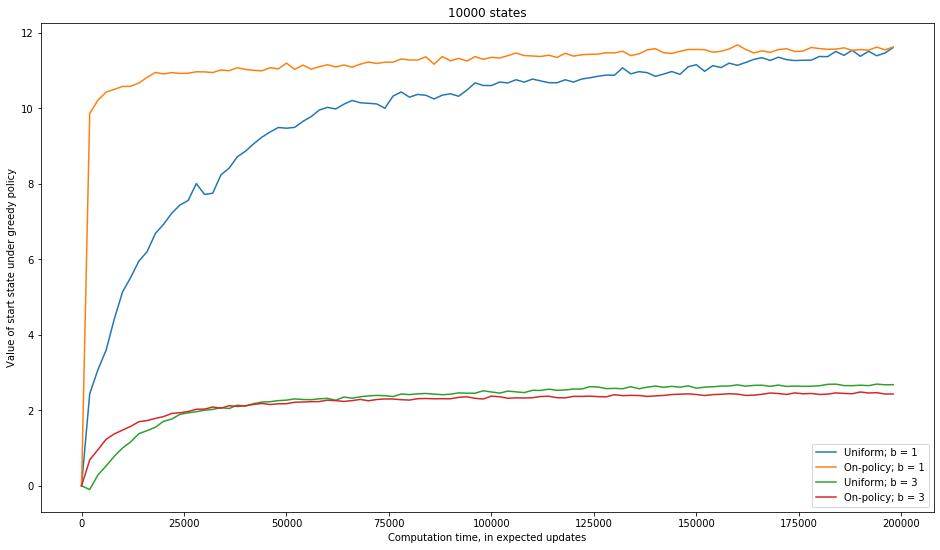

In [22]:
plot_vs(Vs[10000], 10000)